In [ ]:
# !pip install datasets vit-pytorch torch Linformer torchvision matplotlib torch numpy

In [2]:
import torch 
torch.__version__

'1.11.0+cu113'

In [6]:
!nvidia-smi

Tue Jan 17 16:14:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 495.44       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:E1:00.0 Off |                  N/A |
| 30%   24C    P8    31W / 350W |      0MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [84]:
from vit_pytorch.efficient import ViT
import vit_pytorch
from datasets import load_dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F 
import torch
import torch.nn as nn
import torch.optim as optim
from linformer import Linformer
import time

In [4]:
print("Hello World")
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Hello World
Using cuda


## LOAD DATA

In [5]:
# Load, split data
food = load_dataset("food101", split="train[:1000]")
food = food.train_test_split(test_size=0.2)
# Map label ids with label names
labels = food["test"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label
print(f"Train: {len(food['train'])}")
print(f"Test: {len(food['test'])}")

Found cached dataset food101 (/root/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295)


Train: 800
Test: 200


## Image Augmentation

In [6]:
patch_size = 32
image_size = 256
half_size = 112

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((half_size, half_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
        transforms.Resize((half_size, half_size)),
        transforms.ToTensor(),
])

In [8]:
# Make my Special Input Matrix
def mk_special_matrix(tmp):
    ret = torch.cat([tmp[:,patch_size//2:,:], tmp[:,-patch_size//2:,:]], dim=1) # Cut the TOP half-patch-sized slice and cat to the BOTTOM
    res = torch.cat([ret[:,:,-patch_size//2:], ret[:,:,patch_size//2:]], dim=2) # Cut the LEFT half-patch-sized slice and cat to the RIGHT
    return res


def mk_big_matrix(tmp, is_special=False):
    """
        Make an (image_size x image_size) sized matrix that contains
        -> is_special == FALSE :
            WHETHER contains a 
              2x2 Matrix of tmp /                 \ 
                                | TMP      TMP    |
                                |                 |
                                | TMP      TMP    |
                                \                 / 2x2
        -> is_special == TRUE :
            OR      contains a
                                /                 \  
                                | TMP      SPECIAL| 
                                |                 |
                                | SPECIAL  TMP    |
                                \                 / 2x2                        
    """
    special = tmp
    if is_special:
        special = mk_special_matrix(tmp)
    up = torch.cat([tmp, special], dim=1)
    down = torch.cat([special, tmp], dim=1)
    big_matrix = torch.cat([up, down], dim=2)
    return big_matrix

In [9]:
# Normal Train and Test Data
train_data, test_data = dict(), dict()
train_data["img"] = [mk_big_matrix(train_transform(f)) for f in food["train"]["image"]]
train_data["label"] = food["train"]["label"]
test_data["img"] = [mk_big_matrix(test_transform(f)) for f in food["test"]["image"]]
test_data["label"] = food["test"]["label"]
print(f"INPUT SIZE: {train_data['img'][0].size()}")
print(f"Train: {len(train_data['label'])}")
print(f"Test: {len(test_data['label'])}")

# Special Train and Test Data
train_data_S, test_data_S = dict(), dict()
train_data_S["img"] = [mk_big_matrix(train_transform(f), True) for f in food["train"]["image"]]
train_data_S["label"] = food["train"]["label"]
test_data_S["img"] = [mk_big_matrix(test_transform(f), True) for f in food["test"]["image"]]
test_data_S["label"] = food["test"]["label"]
print(f"INPUT SIZE: {train_data_S['img'][0].size()}")
print(f"Train: {len(train_data_S['label'])}")
print(f"Test: {len(test_data_S['label'])}")

INPUT SIZE: torch.Size([3, 224, 224])
Train: 800
Test: 200
INPUT SIZE: torch.Size([3, 224, 224])
Train: 800
Test: 200


## Plots

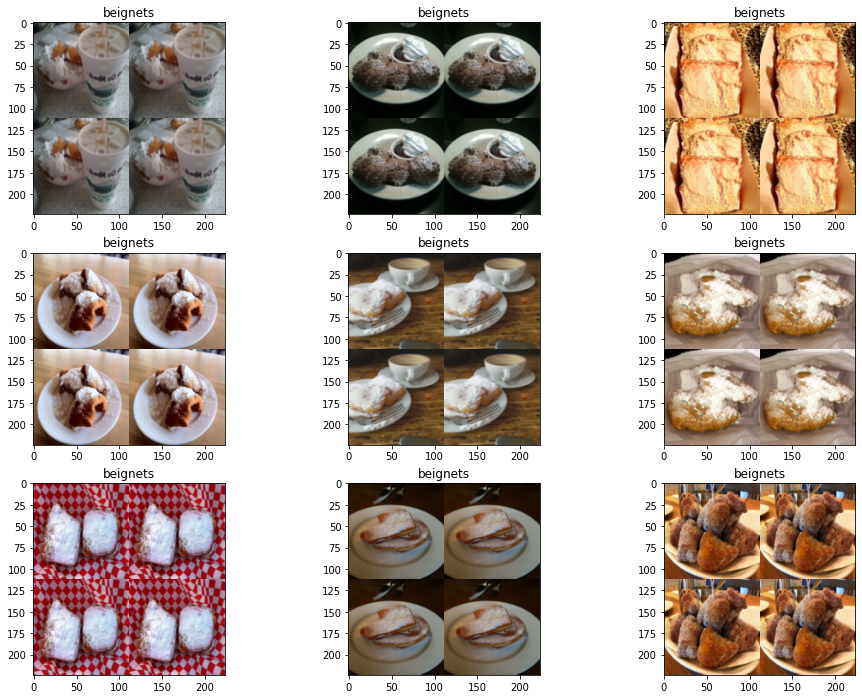

In [10]:
fig, axes = plt.subplots(3,3,figsize=(16,12))
for idx, ax in enumerate(axes.ravel()):
    label = train_data["label"][idx]
    img = train_data["img"][idx]
    ax.set_title(id2label[str(label)])
    image = transforms.ToPILImage()(img).convert('RGB')
    ax.imshow(image)

## DataLoader Wrapping

In [11]:
class MyDataset(Dataset):
    def __init__(self, File, transform=None):
        self.File = File 

    # Get Current File Length
    def __len__(self):
        self.filelength=len(self.File['img'])
        return self.filelength
  
    def __getitem__(self, idx):
        label = self.File["label"][idx]
        img = self.File["img"][idx]
        return img, label

In [12]:
train_my_data = MyDataset(train_data)
test_my_data = MyDataset(test_data)
train_my_data_S = MyDataset(train_data_S)
test_my_data_S = MyDataset(test_data_S)

In [13]:
train_loader = DataLoader(dataset=train_my_data, batch_size = 15, shuffle=True)
test_loader = DataLoader(dataset=test_my_data, batch_size = 15, shuffle=True)
train_loader_S = DataLoader(dataset=train_my_data_S, batch_size = 15, shuffle=True)
test_loader_S = DataLoader(dataset=test_my_data_S, batch_size = 15, shuffle=True)

## Model Definition

In [40]:
ModelDict = dict()

In [41]:
# Normal ViT Model
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64,
)
model_vit_efficient = ViT(
    dim=128,
    image_size=image_size,
    patch_size=patch_size,
    num_classes=len(labels),
    transformer=efficient_transformer,
    channels=3,
).to(device)
ModelDict["EFFICT_ViT"] = model_vit_efficient

In [42]:
# Normal ViT
model_vit = vit_pytorch.ViT(
    dim=128,
    image_size=image_size,
    patch_size=patch_size,
    num_classes=len(labels),
    depth=12,
    heads=8,
    mlp_dim=128,
).to(device)
ModelDict["ViT"] = model_vit

In [43]:
# Deep Vit
from vit_pytorch.deepvit import DeepViT
model_deepvit = DeepViT(
    image_size = image_size,
    patch_size = patch_size,
    num_classes = len(labels),
    dim = 128,
    depth = 12,
    heads = 8,
    mlp_dim = 128,
).to(device)
ModelDict["Deepvit"] = model_deepvit

In [44]:
# CaiT Model
from vit_pytorch.cait import CaiT
model_cait = CaiT(
    image_size = image_size,
    patch_size = patch_size,
    num_classes = len(labels),
    dim = 128,
    depth = 12,             # depth of transformer for patch to patch attention only
    cls_depth = 2,          # depth of cross attention of CLS tokens to patch
    heads = 8,
    mlp_dim = 128,
).to(device)
ModelDict["cait"] = model_cait

##  Training

In [19]:
print("Hello World")

Hello World


In [87]:
def trainit(model, train_loader, test_loader, name="DefaultName",lr=3e-5,EPOCH=30):
    """
        Train Model on dataset
            INPUT: 
                - model:           Defined model
                - train_loader:    training data     ->  DataLoader(MyDataset, batchSize, Shutffled)
                - test_loader:     test data         ->  DataLoader(MyDataset, batchSize, Shutffled)
                - name:            Name of the model ->  (default "DefaultName")
                - lr:              Learning Reate    ->  (default 1e-5)
                - EPOCH:           Total Epoches     ->  (default 10) 
            OUTPUT: 
                - model:           After Training 
                - val_loss_list:   Validation Loss respect to Epoch 
                - train_loss_list: Training Loss respect to Epoch
    """
    
    tRet = []
    criterio = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loss_list = []
    val_loss_list = []
    for epoch in range(EPOCH):
        t0 = time.time()
        epoch_loss = 0
        epoch_accuracy = 0
        i = 0
        for data, label in train_loader:
            i += 1
            data = data.to(device)
            label = label.to(device) 
            output = model(data) 
            loss = criterio(output, label) 

            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step() 

            acc = (output.argmax(dim=1)==label).float().mean() 
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader) 
            print(f"Epoch: {epoch+1}/{EPOCH}, {i}/{len(train_loader)} | Acc: {epoch_accuracy:.4f} | Los: {epoch_loss:.4f}", end='\r')
        with torch.no_grad(): 
            epoch_val_acc = 0 
            epoch_val_loss = 0
            for data, label in test_loader:
                data = data.to(device)
                label = label.to(device)
                val_output = model(data)
                val_loss = criterio(val_output, label) 
                acc = (val_output.argmax(dim=1)==label).float().mean() 
                epoch_val_acc += acc / len(test_loader)
                epoch_val_loss += val_loss / len(test_loader)
        val_loss_list.append(epoch_val_loss)
        train_loss_list.append(epoch_loss)
        t1 = time.time()
        bias = t1 - t0
        print(f"{name:15s} > Epoch: {epoch+1:2d}/{EPOCH} | Loss: {epoch_loss:.4f} | acc: {epoch_accuracy:4f} | val_loss: {epoch_val_loss: .4f} | val_acc: {epoch_val_acc: .4f} | Time: {bias}")
        tRet.append(bias)
    print(f"{name:15s} > Time Usage: {sum(tRet):.4f}s")
    return model, train_loss_list, val_loss_list, tRet

In [37]:
for key in ModelDict:
    print(f"{key} ->")

efficientViT ->
ViT ->
Deepvit ->
cait ->


In [91]:
TrainLossDict, ValLossDict, ModelOK, TimeDict = dict(), dict(), dict(), dict()
for key in ModelDict:
    print(key)
    ModelOK[key], TrainLossDict[key], ValLossDict[key], TimeDict[key] = trainit(ModelDict[key], train_loader, test_loader, key)
key = "ViT_INPUTVARY"
ModelOK[key], TrainLossDict[key], ValLossDict[key], TimeDict[key] = trainit(ModelDict["ViT"], train_loader_S, test_loader_S, key)

EFFICT_ViT
EFFICT_ViT      > Epoch:  1/30 | Loss: 0.3710 | acc: 0.837037 | val_loss:  0.3580 | val_acc:  0.8571 | Time: 3.1938934326171875
EFFICT_ViT      > Epoch:  2/30 | Loss: 0.3343 | acc: 0.851852 | val_loss:  0.3603 | val_acc:  0.8381 | Time: 3.1663155555725098
EFFICT_ViT      > Epoch:  3/30 | Loss: 0.3382 | acc: 0.840741 | val_loss:  0.4276 | val_acc:  0.8048 | Time: 2.820465564727783
EFFICT_ViT      > Epoch:  4/30 | Loss: 0.3353 | acc: 0.830864 | val_loss:  0.4218 | val_acc:  0.7952 | Time: 2.8914310932159424
EFFICT_ViT      > Epoch:  5/30 | Loss: 0.3005 | acc: 0.869136 | val_loss:  0.3953 | val_acc:  0.8286 | Time: 3.1179704666137695
EFFICT_ViT      > Epoch:  6/30 | Loss: 0.2800 | acc: 0.877778 | val_loss:  0.4190 | val_acc:  0.7952 | Time: 3.1947598457336426
EFFICT_ViT      > Epoch:  7/30 | Loss: 0.2705 | acc: 0.883951 | val_loss:  0.4369 | val_acc:  0.7905 | Time: 3.184448003768921
EFFICT_ViT      > Epoch:  8/30 | Loss: 0.2493 | acc: 0.895062 | val_loss:  0.4083 | val_acc:  0

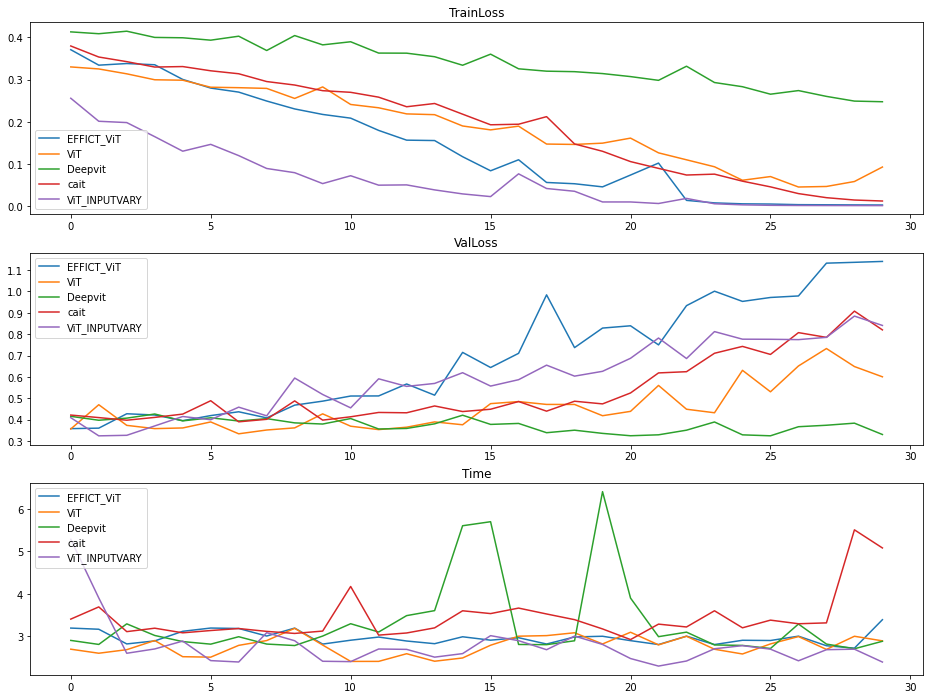

In [93]:
fig, axes = plt.subplots(3,1,figsize=(16,12))
names = ['TrainLoss','ValLoss','Time']
sources = [TrainLossDict, ValLossDict,TimeDict]
for idx, ax in enumerate(axes.ravel()):
    Dict = sources[idx]
    name = names[idx]
    length = len(Dict[key])
    ax.set_title(name)
    for key in Dict:
        try: 
            tmp = np.array(Dict[key])
        except:    
            tmp = [d.cpu().detach().numpy() for d in Dict[key]]
        ax.plot(np.arange(length), np.array(tmp), label=key)
        ax.legend()
plt.show()
    